In [1]:
# Import Libraries

import psutil
import ray
import numpy as np
from matplotlib import pyplot as plt
import multiprocessing as mp
from pprint import pprint as pp
import math
import timeit

In [2]:
# Sequential Dot Product

def SeqDotProd(A, B):

  m, n = A.shape
  n, p = B.shape

  ret = np.zeros(shape=(m, p))

  for i in range(m):
    for j in range(p):
      ret[i, j] = 0
      for k in range(n):
        ret[i, j] += A[i, k] * B[k, j]
  
  return ret

In [3]:
# Test Sequential Dot Product

A = np.random.randint(0, 10, size=(3, 3))
B = np.random.randint(0, 10, size=(3, 3))

C = SeqDotProd(A, B)

pp(C)
pp(C.shape)

array([[71., 43., 75.],
       [78., 21., 81.],
       [87., 21., 75.]])
(3, 3)


In [8]:
# Parallel Dot Product

@ray.remote
class ParDotProdClass(object):
    
    def __init__(self, A, B, N):
        
        self.m = A.shape[0]
        self.n = B.shape[0]
        self.p = B.shape[1]
        
        self.ret = np.zeros(shape=(self.m, self.p))
        
        self.row = 0
        self.col = 0
        self.step_size = math.ceil(self.m/N)
        
    def get_value(self):
        return self.ret
    
    def inc(self):
        
        rs = self.row * self.step_size
        re = min(self.m, rs + self.step_size)
    
        cs = self.col * self.step_size
        ce = min(self.p, cs * self.step_size)
        
        for i in range(rs, re):
            for j in range(cs, ce):
              self.ret[i, j] = 0
              for k in range(self.n):
                self.ret[i, j] += A[i, k] * B[k, j]
        
        self.row += 1
        self.col += 1


def ParDotProd(A, B, N):
    
    ray.shutdown()
    ray.init(num_cpus=N)
    
    shared_a = ray.put(A)
    shared_b = ray.put(B)
    
    parObj = ParDotProdClass.remote(shared_a, shared_b, N)
    
    for _ in range(N):
        parObj.inc.remote()

    return ray.get(parObj.get_value.remote())

In [9]:
# Test Parallel Dot Product

C = ParDotProd(A, B, 2)

pp(C)
pp(C.shape)

2019-11-26 13:21:17,768	INFO resource_spec.py:205 -- Starting Ray with 4.2 GiB memory available for workers and up to 2.1 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ..., 2110., 1758., 1610.],
       [   0.,    0.,    0., ..., 1693., 1733., 1625.],
       [   0.,    0.,    0., ..., 2066., 1683., 1784.]])
(100, 100)


In [10]:
# Benchmark

seq_times = []
par_times_2 = []
par_times_4 = []
par_times_6 = []
par_times_8 = []
sizes = []

for n in range(10, 101, 10):
    
    A = np.random.randint(0, 10, size=(n, n))
    B = np.random.randint(0, 10, size=(n, n))

    tt_seq = timeit.timeit(
      setup="from __main__ import SeqDotProd, A, B",
      stmt='SeqDotProd(A, B)',
      number=1
    )
    
    tt_par_2 = timeit.timeit(
      setup="from __main__ import ParDotProd, A, B",
      stmt='ParDotProd(A, B, 2)',
      number=1
    )
    
    tt_par_4 = timeit.timeit(
      setup="from __main__ import ParDotProd, A, B",
      stmt='ParDotProd(A, B, 4)',
      number=1
    )
        
    tt_par_6 = timeit.timeit(
      setup="from __main__ import ParDotProd, A, B",
      stmt='ParDotProd(A, B, 6)',
      number=1
    )
            
    tt_par_8 = timeit.timeit(
      setup="from __main__ import ParDotProd, A, B",
      stmt='ParDotProd(A, B, 8)',
      number=1
    )
    
    seq_times.append(tt_seq)
    par_times_2.append(tt_par_2)
    par_times_4.append(tt_par_4)
    par_times_6.append(tt_par_6)
    par_times_8.append(tt_par_8)
    sizes.append(n)

2019-11-26 13:21:20,181	INFO resource_spec.py:205 -- Starting Ray with 4.15 GiB memory available for workers and up to 2.08 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-26 13:21:22,305	INFO resource_spec.py:205 -- Starting Ray with 4.15 GiB memory available for workers and up to 2.08 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-26 13:21:24,629	INFO resource_spec.py:205 -- Starting Ray with 4.1 GiB memory available for workers and up to 2.07 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-26 13:21:27,034	INFO resource_spec.py:205 -- Starting Ray with 4.15 GiB memory available for workers and up to 2.09 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-26 13:21:29,849	INFO resource_spec.py:205 -- Starting Ray with 4.1 Gi

2019-11-26 13:22:55,072	INFO resource_spec.py:205 -- Starting Ray with 4.15 GiB memory available for workers and up to 2.08 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-26 13:22:58,759	INFO resource_spec.py:205 -- Starting Ray with 4.2 GiB memory available for workers and up to 2.11 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-26 13:23:00,847	INFO resource_spec.py:205 -- Starting Ray with 4.1 GiB memory available for workers and up to 2.06 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-26 13:23:03,373	INFO resource_spec.py:205 -- Starting Ray with 4.1 GiB memory available for workers and up to 2.06 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-26 13:23:06,903	INFO resource_spec.py:205 -- Starting Ray with 4.1 GiB 

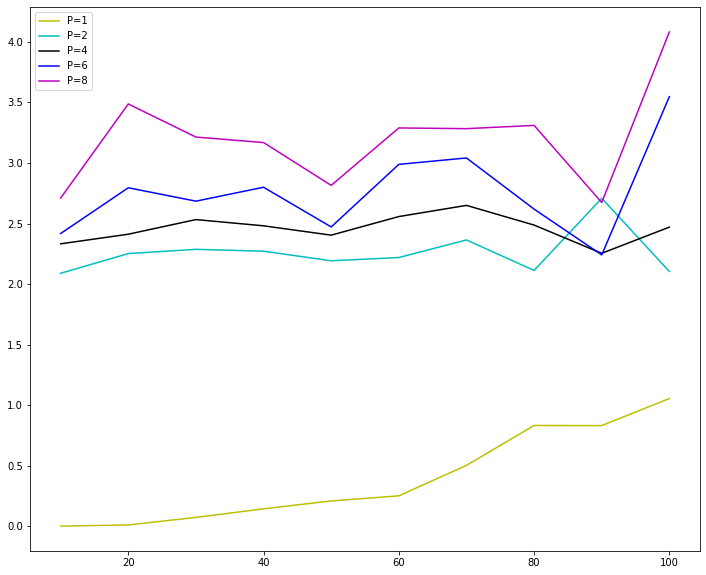

In [11]:
fig = plt.figure(figsize=(12, 10))
plt.plot(sizes, seq_times, label='P=1', c='y')
plt.plot(sizes, par_times_2, label='P=2', c='c')
plt.plot(sizes, par_times_4, label='P=4', c='k')
plt.plot(sizes, par_times_6, label='P=6', c='b')
plt.plot(sizes, par_times_8, label='P=8', c='m')
plt.legend()
plt.show();